**Lib**

In [1]:
from google.colab import drive
import pandas as pd
import os
from tqdm import tqdm
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Concatenate, Resizing, Rescaling, RandomFlip, \
                        RandomRotation, Dropout, GlobalAveragePooling2D, RandomZoom, Flatten
from keras.models import Model, Input, Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow import keras
import matplotlib.pyplot as plt

**Drive**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Path**

In [ ]:
model_path = '/content/drive/MyDrive/Projects/IS254/Code/models'
checkpoint_path = '/content/drive/MyDrive/Projects/IS254/Code/checkpoints'
data_path = '/content/drive/MyDrive/Projects/IS254/Code/image_by_class'

Xoá ảnh lỗi

In [ ]:
!find $data_path/covid -size  0 -print -delete
!find $data_path/pneumonia -size  0 -print -delete
!find $data_path/normal -size  0 -print -delete

**Const**

In [3]:
img_size_target = 224
batch_size = 32
num_classes = 3
epochs = 60
seed = 111

**Model**

Load datasets

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path + '/train',
  seed=seed,
  color_mode = 'rgb',
  image_size=(img_size_target, img_size_target), # resize
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path + '/valid',
  seed=seed,
  color_mode = 'rgb',
  image_size=(img_size_target, img_size_target), # resize
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_path + '/test',
  seed=seed,
  color_mode = 'rgb',
  image_size=(img_size_target, img_size_target), # resize
  batch_size=batch_size)

Found 1182 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 146 files belonging to 3 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
class_names = train_ds.class_names
print(class_names)

['covid', 'normal', 'pneumonia']


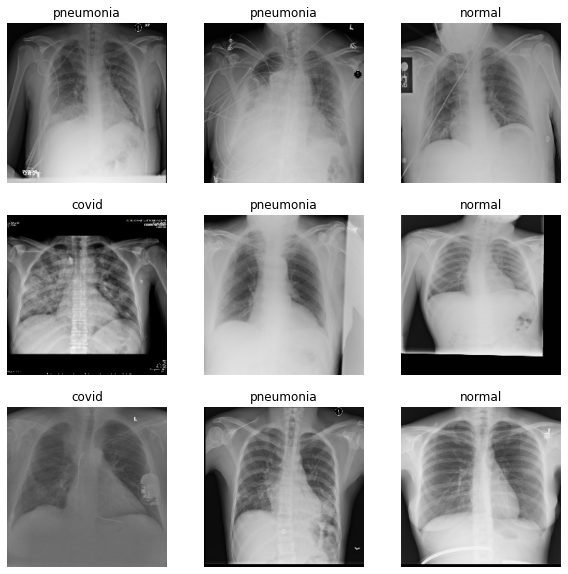

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

enhance = Sequential([
    Rescaling(1./255)  # rescaling
    ], name='enhance')

augmentation = Sequential([
    RandomFlip(seed=seed, mode='horizontal'), # flip
   ], name='augmentation')

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (enhance(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

VGG16

In [4]:
vgg16 = VGG16(include_top=False, pooling='avg', input_shape=(img_size_target, img_size_target, 3), weights='imagenet')

for layer in vgg16.layers:
    layer.trainable = False

fc1 = Dense(32, activation='relu')(vgg16.layers[-1].output)

fc1 = Dropout(0.4)(fc1)

output = Dense(num_classes, activation='softmax')(fc1)

model_vgg16 = Model(inputs=vgg16.inputs, outputs=output)

model_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

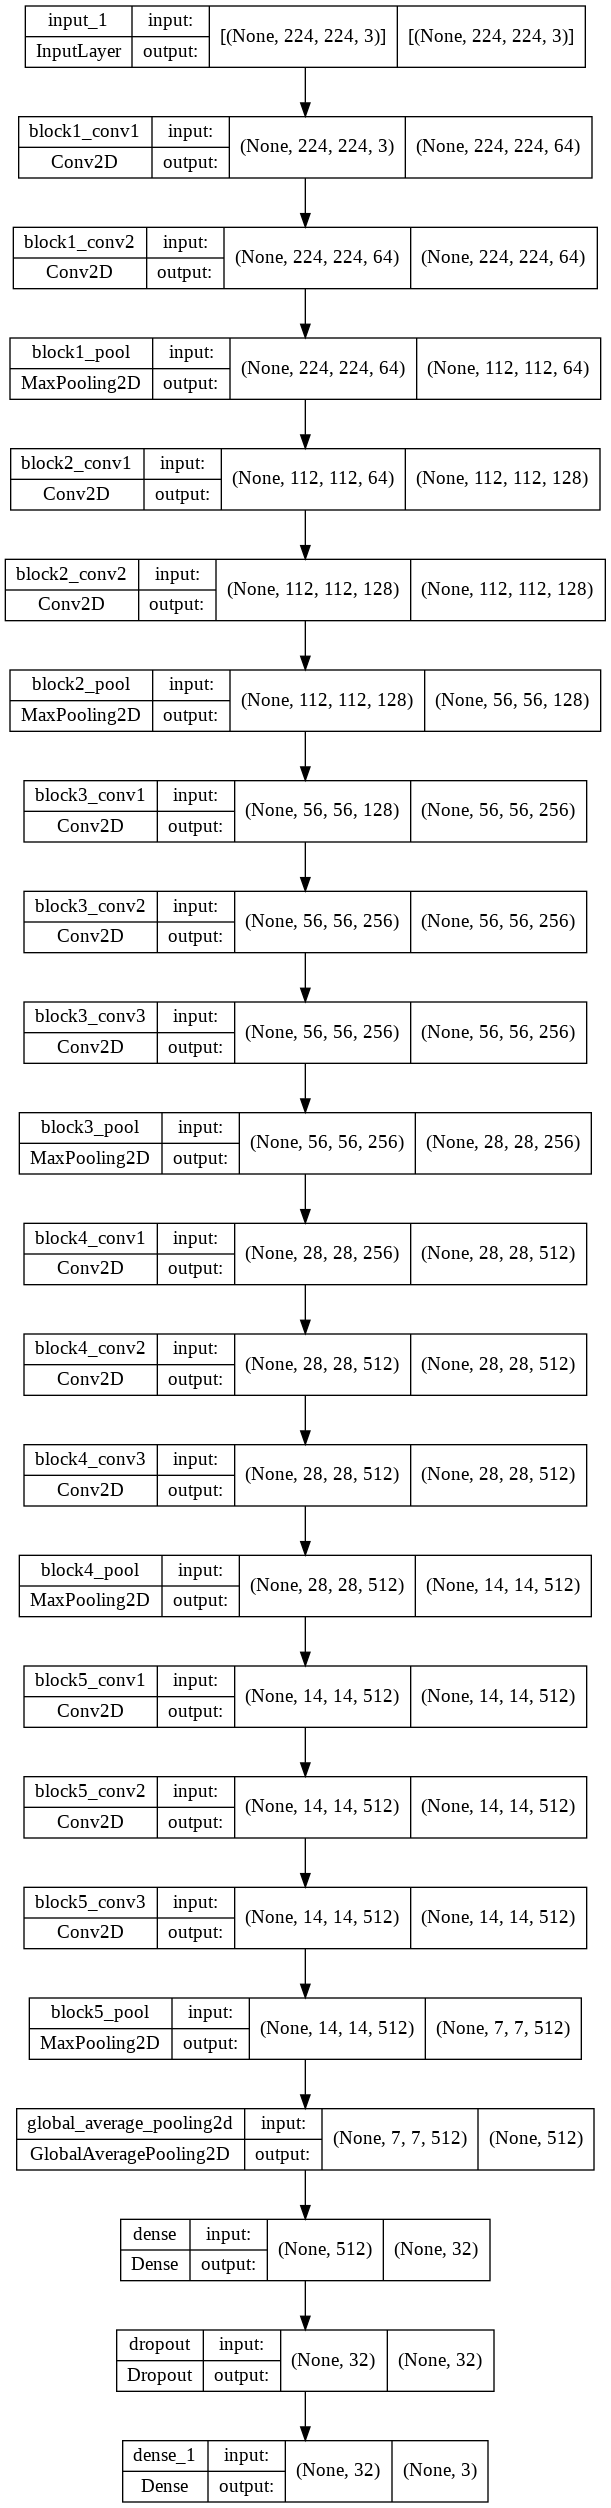

In [9]:
tf.keras.utils.plot_model(
    model_vgg16,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
   # rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

Complile

In [ ]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mcp_save = ModelCheckpoint(checkpoint_path + '/vgg16_midnight-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto') 
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

Training

In [ ]:
history = model_vgg16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[mcp_save, reduce_lr_loss]
)

Epoch 1/60
37/37 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.3985
Epoch 1: val_loss improved from inf to 1.01498, saving model to /content/drive/MyDrive/Projects/IS254/Code/checkpoints/vgg16_midnight-001-0.398477-0.520000.h5
37/37 [==============================] - 265s 3s/step - loss: 1.1580 - accuracy: 0.3985 - val_loss: 1.0150 - val_accuracy: 0.5200 - lr: 0.0100
Epoch 2/60
37/37 [==============================] - ETA: 0s - loss: 0.9688 - accuracy: 0.4949
Epoch 2: val_loss improved from 1.01498 to 0.92637, saving model to /content/drive/MyDrive/Projects/IS254/Code/checkpoints/vgg16_midnight-002-0.494924-0.580000.h5
37/37 [==============================] - 31s 384ms/step - loss: 0.9688 - accuracy: 0.4949 - val_loss: 0.9264 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 3/60
37/37 [==============================] - ETA: 0s - loss: 0.9203 - accuracy: 0.5093
Epoch 3: val_loss improved from 0.92637 to 0.90779, saving model to /content/drive/MyDrive/Projects/IS254/Co

Saving

In [ ]:
model_vgg16.save(model_path+ '/vgg16_midnight-final.h5')

**Plot**

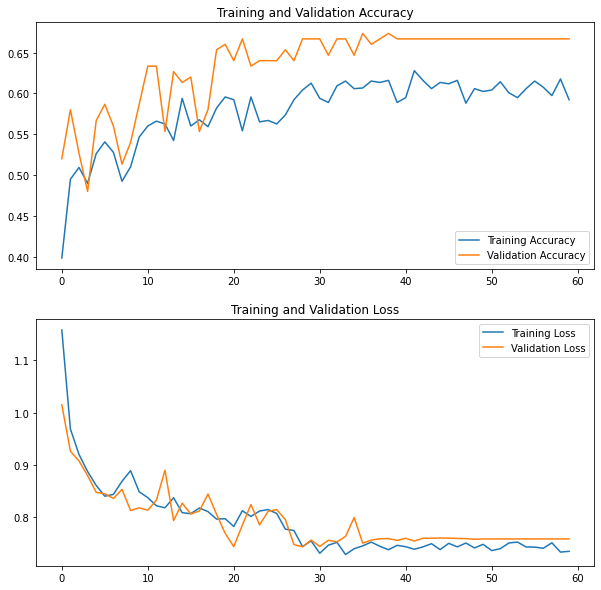

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()